In [1]:
import pyms
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from DM1dCalc import multislice

Parameters for the calculations

In [4]:
# Parameters
eV = 200e3; app = None; gridshape = [48, 48]; thicknesses = 171
crystal = pyms.structure.fromfile("../structures/STO_3bc.xyz", atomic_coordinates="cartesian")

# Subslicing and tiling
subslices = [0.33, 0.66, 1.0]
#tiling = [1,2]
tiling = [1,1]

# Calculate grid size in Angstrom
rsize = np.zeros(3)
rsize[:3] = crystal.unitcell[:3]
rsize[:2] *= np.asarray(tiling)

# Grid size in Angstrom
gridsize = np.asarray(tiling)*crystal.unitcell[:2]

#Defocii for an image series
#defocii = np.arange(-82.5, 83, 2.5)*10
defocii = np.arange(-30, 34, 2)*10
#defocii = 0

# Choose device (CPU or GPU) to run calculations on
device = torch.device('cuda:0')

# Target the Titanium K edge
Ztarget = 22; n=2; ell=1; epsilon = 10

Transition potential calculations with dipole approximation

In [5]:
from pyms.Probe import wavev
eV = 200e3
deltaE = -456
# Calculate wave number in inverse Angstrom of incident and scattered
# electrons
k0 = wavev(eV)
kn = wavev(eV + deltaE)

# Minimum momentum transfer at this energy loss
qz = k0 - kn

# Get grid dimensions in reciprocal space in units of inverse Bohr radii
# (to match atomic wave function output from the Flexible Atomic Code)
qq = [gridshape[i] / gridsize[i] for i in range(2)]
deltaq = [1 / gridsize[i] for i in range(2)]
qgrid = [np.fft.fftfreq(gridshape[1]) * qq[0], np.fft.fftfreq(gridshape[0]) * qq[1]]
qx, qy = qgrid
Qx, Qy = np.meshgrid(qx, qy, indexing='ij')
theta = 7 * np.pi / 180  # 7 degrees in radians
Qxp = Qx * np.cos(theta) - qz * np.sin(theta)
Qyp = Qy
Qzp = Qx * np.sin(theta) + qz * np.cos(theta)
sampling = gridsize / gridshape
rx = np.linspace(-gridsize[0] / 2, gridsize[0] / 2, gridshape[0])
ry = np.linspace(-gridsize[1] / 2, gridsize[1] / 2, gridshape[1])
Rx, Ry = np.meshgrid(rx, ry, indexing='ij')

# Transverse momentum transfer
Q2 = Qx ** 2 + Qy ** 2

Hx = np.fft.ifft2(Qxp/(Q2 + qz**2))
Hy = np.fft.ifft2(Qyp/(Q2 + qz**2))
Hz = np.fft.ifft2(Qzp/(Q2 + qz**2))
nx, ny, nz = 1, 1, 1
Hdipole = [nx*Hx, ny*Hy, nz*Hz]

Conduct multislice calculations (py-multislice)

In [12]:
#EFTEM_images, density_matrix = pyms.EFTEM(
EFTEM_images = pyms.EFTEM(
    crystal,
    gridshape,
    eV,
    app,
    thicknesses,
    Ztarget,
    n,
    ell,
    epsilon,
    Hn0=Hdipole,
    df=defocii,
    subslices=subslices,
    device_type=None,
    tiling=tiling,
    nT=0,
    showProgress = 'notebook',
    #option=2,
    option=0,
    axis=0,
    #limit=2/3
)
#np.save("calculated_density_matrix.npy", density_matrix)
#np.save("calculated_density_matrix_dipole.npy", density_matrix[0,:,:])
np.save("calculated_EFTEM_images_dipole.npy", EFTEM_images)

Frozen phonon iterations::   0%|          | 0/5 [00:00<?, ?it/s]

Note: will use thermally-smeared elastic potential plus TDS absorptive potential


Calculating TDS scattering factors:   0%|          | 0/22 [00:00<?, ?it/s]

Calculating TDS scattering factors:   0%|          | 0/22 [00:00<?, ?it/s]

Calculating TDS scattering factors:   0%|          | 0/22 [00:00<?, ?it/s]

Slice:   0%|          | 0/18 [00:00<?, ?it/s]

Slice:   0%|          | 0/18 [00:00<?, ?it/s]

Slice:   0%|          | 0/18 [00:00<?, ?it/s]

Slice:   0%|          | 0/18 [00:00<?, ?it/s]

Slice:   0%|          | 0/18 [00:00<?, ?it/s]

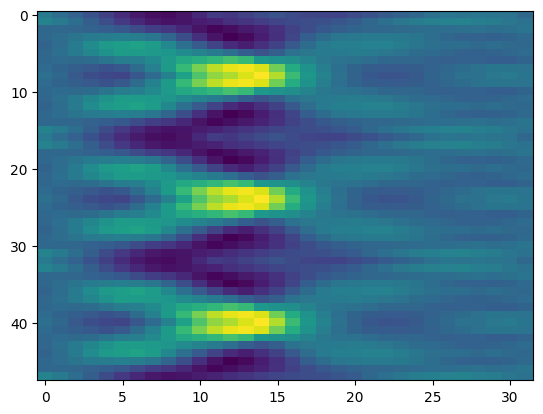

In [13]:
profile = np.mean(EFTEM_images, axis=1)
plt.imshow(profile.T, aspect='auto')
plt.show()